# Google Earth Engine Component

## Initialize

In [2]:
!pip install ee

  Created wheel for ee: filename=ee-0.2-py3-none-any.whl size=3675 sha256=bc2bb977a48558cfd501fa066b79089728866e8ceabff93b2f75cd5be6328152
  Stored in directory: /root/.cache/pip/wheels/0b/12/c0/b52afbb4093f67c02dac5869ef6bad845a234e2bd76bd803e9
Successfully built ee


In [3]:
!pip install geemap

     |████████████████████████████████| 2.0 MB 22.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 73.3 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 5.6 MB/s  eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 239 kB 56.3 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 8.8 MB/s  eta 0:00:01
     |████████████████████████████████| 130 kB 72.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 70.7 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 16.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 75.6 MB/s eta 0:00:01
     |████████████████████████████████| 187 kB 72.9 MB/s eta 0:00:01
     |████████████████████████████████| 99 kB 19.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 73.3 MB/s eta 0:00:01
     |████████████████████████████████| 106 kB 76.

     |████████████████████████████████| 77 kB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 9.6 MB/s  eta 0:00:01
     |████████████████████████████████| 76 kB 12.4 MB/s eta 0:00:01


     |████████████████████████████████| 15.2 MB 55.6 MB/s eta 0:00:01
  Created wheel for earthengine-api: filename=earthengine_api-0.1.315-py3-none-any.whl size=268411 sha256=a7ef76dbc34f1119f6ed011f5f94c4c2e0d8a46b1bef1a193684a8dfe1ad2cb1
  Stored in directory: /root/.cache/pip/wheels/75/8c/db/8d58fd3c0154e5a023e0ff7c3ec1d85f61b3872abe553fb4d8
  Created wheel for ee-extra: filename=ee_extra-0.0.13-py3-none-any.whl size=198382 sha256=93274e9b88d8ac34c76ffdc60626cf64e6bdea2925e0cb3dadba147477ca3c98
  Stored in directory: /root/.cache/pip/wheels/99/95/78/eeee7313080552ade64452acc7f7acfe9d6010d1915e96b897
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14759 sha256=8cbc485d4c3ec3bf75b20caaa336aae6745d9f44b7df9fba6861eb310b48efb0
  Stored in directory: /root/.cache/pip/wheels/7b/7b/5d/656f46cd6889e4c93977be9586901d0adc1271b2d876c84c96
  Created wheel for httplib2shim: filename=httplib2shim-0.0.3-py2.py3-none-any.whl size=18059 sha256=44c1783492094f9d90632a5a54a1bd7f4

In [4]:
!pip install varname

In [5]:
#Import required libraries
import ee
import geemap
import math

import numpy as np
import matplotlib.pyplot as plt

import itertools
# from varname import nameof

import pandas as pd
from time import time

In [6]:
#Initialize Google Earth Engine
#ee.Authenticate() #just needed the 1st time
ee.Initialize()

Enter verification code: 4/1AX4XfWiK60qqLajOAC5inxhWD-Oji4hf0fOZpAMBl9BSzkMVpsYWywtc-dA

Successfully saved authorization token.


In [7]:
# Check if geemap is working as intended - plot the leaflet map
Map = geemap.Map()

In [8]:
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Load Feature Collection - Shapefiles

In [9]:
#Data loads

#loads feature collection data from Google Earth Engine - We can also upload other feature collections
counties = ee.FeatureCollection("TIGER/2018/Counties")

#filter LA County
la_county = counties.filter(ee.Filter.eq('NAME', 'Los Angeles'))
sc_county = counties.filter(ee.Filter.eq('NAME', 'Santa Clara'))

In [10]:
la_county, sc_county

(<ee.featurecollection.FeatureCollection at 0x7fe035e11e80>,
 <ee.featurecollection.FeatureCollection at 0x7fe035e11e20>)

## Load NAIP Imagery

In [11]:
def apply_3bands(image, band):
    i_8_bit = image.select(band).toUint8()
    square = ee.Kernel.square(**{'radius': 4})
    entropy = i_8_bit.entropy(square)
    glcm = i_8_bit.glcmTexture(**{'size': 4})
    contrast = glcm.select(str(band)+'_contrast')
    
    # Create a list of weights for a 9x9 kernel.
    list = [1, 1, 1, 1, 1, 1, 1, 1, 1]
    # The center of the kernel is zero.
    centerList = [1, 1, 1, 1, 0, 1, 1, 1, 1]
    # Assemble a list of lists: the 9x9 kernel weights as a 2-D matrix.
    lists = [list, list, list, list, centerList, list, list, list, list]
    # Create the kernel from the weights.
    # Non-zero weights represent the spatial neighborhood.
    kernel = ee.Kernel.fixed(9, 9, lists, -4, -4, False)
    neighs = i_8_bit.neighborhoodToBands(kernel)
    gearys = i_8_bit.subtract(neighs).pow(2).reduce(ee.Reducer.sum()).divide(math.pow(9, 2))
    image = image.addBands(entropy.rename(str(band)+'_Entropy')).addBands(contrast.rename(str(band)+'_Contrast')).addBands(gearys.rename(str(band)+'_Gearys'))   
    return image

def add_neighborhood_bands(image):
    bands = ['R', 'G', 'B', 'N']
    for band in bands:
        image = apply_3bands(image, band)
    return image
    
def add_NDVI(image):
    image = image.addBands(image.normalizedDifference(['N','R']).rename('NDVI'))
    return image
     

In [12]:
def get_images(param_dict):
    source_image_collection = params['source_image_collection']
    years = param_dict['years']
    counties = param_dict['counties']

    image_names = []
    images = []

    combos = list(itertools.product(years, counties.keys()))
    for i in combos:
        year = str(i[0])
        county = i[1]

        image_name = str(i[0])+'_'+i[1]
        image_names.append(image_name)

        image = ee.ImageCollection(source_image_collection)\
                                .filterDate(f'{year}-01-01', f'{year}-12-31')\
                                .select(['R','G','B','N'])\
                                .median().clip(counties[county])
        images.append(image)
        images_with_3band = list(map(add_neighborhood_bands, images))
        images_with_NDVI = list(map(add_NDVI, images_with_3band))
    return dict(zip(image_names, images_with_NDVI))

    
    

In [13]:
params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2010,2012,2014,2016,2018,2020],
        'counties': {'la_county': la_county, 'sc_county': sc_county}
         }

images = get_images(params)
images

{'2010_la_county': <ee.image.Image at 0x7fe035ab3550>,
 '2010_sc_county': <ee.image.Image at 0x7fe035ab3730>,
 '2012_la_county': <ee.image.Image at 0x7fe035ab3910>,
 '2012_sc_county': <ee.image.Image at 0x7fe035ab3af0>,
 '2014_la_county': <ee.image.Image at 0x7fe035ab3cd0>,
 '2014_sc_county': <ee.image.Image at 0x7fe035ab3eb0>,
 '2016_la_county': <ee.image.Image at 0x7fe035ab70d0>,
 '2016_sc_county': <ee.image.Image at 0x7fe035ab72b0>,
 '2018_la_county': <ee.image.Image at 0x7fe035ab7490>,
 '2018_sc_county': <ee.image.Image at 0x7fe035ab7670>,
 '2020_la_county': <ee.image.Image at 0x7fe035ab7850>,
 '2020_sc_county': <ee.image.Image at 0x7fe035ab7a30>}

In [14]:
#see what bands each image has:
images['2020_la_county'].bandNames().getInfo()

['R',
 'G',
 'B',
 'N',
 'R_Entropy',
 'R_Contrast',
 'R_Gearys',
 'G_Entropy',
 'G_Contrast',
 'G_Gearys',
 'B_Entropy',
 'B_Contrast',
 'B_Gearys',
 'N_Entropy',
 'N_Contrast',
 'N_Gearys',
 'NDVI']

In [15]:
#test to see if NAIP plot looks correct
Map.addLayer(images['2020_la_county'], {}, 'NAIP Test')

In [16]:
poly = [[-118.180413,33.912948],[-118.193457,33.875639],[-118.285876,33.872960],[-118.280523,33.928753]]

In [17]:
p = ee.Geometry.Polygon(poly)

In [18]:
im = images['2020_la_county']

In [19]:
im.clip(p)

In [20]:
Map.addLayer(p, {}, 'POLYGON TEST')

In [21]:
Map

Map(bottom=437.0, center=[63.7770848268189, 132.29202185776418], controls=(WidgetControl(options=['position', …

In [23]:
#test to see if NDVI plot looks correct 
source_image = images['2020_sc_county']

test_ndvi = source_image.normalizedDifference(['N', 'R']).rename('2020_NDVI')
test_ndvi

In [24]:
Map.addLayer(test_ndvi,{min : -1, max : 1, 'palette' : ['blue', 'white', 'green']}, 'NDVI Test')
Map

Map(bottom=437.0, center=[63.7770848268189, 132.29202185776418], controls=(WidgetControl(options=['position', …

## Load Labeled Data

In [25]:
PROJECT_DIR = 'projects/california-lawn-detection/assets/'

water = ee.FeatureCollection(f"{PROJECT_DIR}water_torrance_0610")
vegetation_trees = ee.FeatureCollection(f"{PROJECT_DIR}trees_torrance")
vegetation_grass = ee.FeatureCollection(f"{PROJECT_DIR}grass_torrance").limit(400)
turf_1 = ee.FeatureCollection(f"{PROJECT_DIR}turf_torrance1")
turf_2 = ee.FeatureCollection(f"{PROJECT_DIR}turf_torrance2")
pv = ee.FeatureCollection(f"{PROJECT_DIR}pv_torrance")
impervious_1 = ee.FeatureCollection(f"{PROJECT_DIR}impervious_torrance1").limit(40)
impervious_2 = ee.FeatureCollection(f"{PROJECT_DIR}impervious_torrance2").limit(40)
soil = ee.FeatureCollection(f"{PROJECT_DIR}soil_torrance").limit(40)

turf = turf_1.merge(turf_2)
impervious= impervious_1.merge(impervious_2)

LABELED_SET = water.merge(vegetation_trees)\
                   .merge(vegetation_grass)\
                   .merge(turf)\
                   .merge(impervious)\
                   .merge(soil)
    
Map.addLayer(LABELED_SET, {}, 'labeled_set')

In [26]:
Map

Map(bottom=437.0, center=[63.7770848268189, 132.29202185776418], controls=(WidgetControl(options=['position', …

## Build Training Set

In [27]:
training_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2020],
        'counties': {'lacounty': la_county}
         }

TRAINING_IMAGE = get_images(training_image_params)['2020_lacounty']

In [28]:
# Overlay the points on the imagery to get training.
LABEL = 'landcover'
BANDS = ['R', 'G', 'B', 'N', 'NDVI',
         'R_Entropy',
         'R_Contrast',
         'R_Gearys',
         'G_Entropy',
         'G_Contrast',
         'G_Gearys',
         'B_Entropy',
         'B_Contrast',
         'B_Gearys',
         'N_Entropy',
         'N_Contrast', 
         'N_Gearys']

training_set = TRAINING_IMAGE.select(BANDS).sampleRegions(**{
  'collection': LABELED_SET,
  'properties': [LABEL],
  'scale': 1
})

In [29]:
set(BANDS)==set(TRAINING_IMAGE.bandNames().getInfo())

True

In [30]:
def training_area(image, training_class):
    
    area = image.reduceRegion(
           reducer = ee.Reducer.count(), 
           geometry = training_class.geometry(), 
           scale = 2, 
           maxPixels = 1e13
                )

    return(area.getInfo().get('B'))

In [31]:
def training_polygons(training_class):
    return(training_class.aggregate_count('label').getInfo())

In [32]:
# training information
training_classes = [water,
                         vegetation_trees,
                         vegetation_grass,
                         turf,
                         pv,
                         impervious,
                         soil]

class_names = ['water',
                         'vegetation_trees',
                         'vegetation_grass',
                         'turf',
                         'pv',
                         'impervious',
                         'soil']

try:
    for i in range(len(training_classes)):
        area_i = training_area(TRAINING_IMAGE, training_classes[i])
        polygons_i = training_polygons(training_classes[i])
        print(class_names[i],"pixels:", area_i ,", polygons", polygons_i)
except:
    print('ERROR. POSSIBLE MISMATCH IN CLASSES LIST AND NAMES LIST SIZES')



water pixels: 486 , polygons 199
vegetation_trees pixels: 17125 , polygons 772
vegetation_grass pixels: 23681 , polygons 400
turf pixels: 857 , polygons 215
pv pixels: 1723 , polygons 344
impervious pixels: 20360 , polygons 80
soil pixels: 8761 , polygons 40


## Separate Training Data into Train/Test

In [33]:
#Split Training and Test Set Randomly - there might be a better way to do this
print("Labeled Set Size in Pixels", training_set.aggregate_count('R').getInfo())
sample = training_set.randomColumn()
trainingSample = sample.filter('random <= 0.8')
validationSample = sample.filter('random > 0.8')
print("Training Set Size in Pixels", trainingSample.aggregate_count('R').getInfo())
print("Test Set Size in Pixels", validationSample.aggregate_count('R').getInfo())

Labeled Set Size in Pixels 284710
Training Set Size in Pixels 227871
Test Set Size in Pixels 56839


## Machine Learning Model

In [34]:
clf = ee.Classifier.smileRandomForest(numberOfTrees = 100).train(trainingSample, LABEL, BANDS)
clf

In [35]:
training_image_classified = TRAINING_IMAGE.select(BANDS).classify(clf)

In [36]:
legend_keys = ['water', 'vegetation_trees', 'vegetation_grass', 'turf','impervious','soil']
legend_colors = ['#0B6AEF', '#097407', '#0CE708', '#8C46D2' ,' #A1A8AF','#D47911']

Map.addLayer(training_image_classified, {'min': 1, 'max': 7, 'palette': legend_colors}, 'Classification')

In [37]:
Map

Map(bottom=437.0, center=[63.7770848268189, 132.29202185776418], controls=(WidgetControl(options=['position', …

## Evaluation Metrics

### Train Accuracy

In [38]:
train_accuracy = trainingSample.classify(clf).errorMatrix('landcover', 'classification')
train_accuracy.getInfo()

[[0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1473, 0, 0, 0, 0, 0, 0],
 [0, 0, 54688, 21, 0, 0, 0, 0],
 [0, 0, 147, 75601, 0, 0, 0, 2],
 [0, 0, 0, 0, 2637, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 65382, 0],
 [0, 0, 0, 0, 0, 0, 1, 27918]]

In [39]:
train_accuracy.accuracy().getInfo()

0.9992451869698207

In [40]:
np.array(train_accuracy.getInfo()).sum()

227871

### Test Accuracy

In [41]:
test_accuracy = validationSample.classify(clf).errorMatrix('landcover', 'classification')

In [42]:
test_accuracy.accuracy().getInfo()

0.9786238322278717

In [43]:
np.array(test_accuracy.getInfo()).sum()

56839

In [44]:
training_image_classified.eq(1).multiply(ee.Image.pixelArea()).getInfo()

{'type': 'Image',
 'bands': [{'id': 'classification',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

## Binary Classification and Area Calculation

In [45]:
def area_calculation(image, class_number, shape, zcode, pixel_scale = 20):
    
    areaImage = image.eq(class_number).multiply(ee.Image.pixelArea())


#     if zcode:
#         area = areaImage.reduceRegion(
#             reducer = ee.Reducer.sum(), 
#             geometry = shape.geometry(), 
#             scale = pixel_scale, 
#             maxPixels = 1e13)
    
#     else:
    area = areaImage.reduceRegion(
        reducer = ee.Reducer.sum(), 
        geometry = shape, 
        scale = pixel_scale, 
        maxPixels = 1e13)

    
    area_sq_m = area.getInfo().get('classification')
    
    area_sq_km = area_sq_m / 1e6
    
    return area_sq_km

In [48]:
la_county_income_zipcode2 = ee.FeatureCollection("projects/california-lawn-detection/assets/income_zipcode2019")
la_county_income_zipcode = la_county_income_zipcode2.select(ee.List(['zipcode', '2019zipcod','shape_area']), ee.List(['ZipCode', 'Median_Income','Area_sqft']))

In [49]:
polygon = la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', '90802'))
area_calculation(training_image_classified, 6, polygon, zcode = True)

12.688005716131128

In [50]:
polygon = la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', '90802'))
area_calculation(training_image_classified, 6, p, zcode = False)

21.622244060719602

In [51]:
Map.addLayer(p, {}, 'coord polygon')

In [52]:
Map.addLayer(polygon, {}, '90802')

In [53]:
Map

Map(bottom=437.0, center=[63.7770848268189, 132.29202185776418], controls=(WidgetControl(options=['position', …

In [54]:
training_image_classified.clip(p)

In [55]:
area_calculation(training_image_classified, 1, p)

TypeError: area_calculation() missing 1 required positional argument: 'zcode'

In [56]:
dir(training_image_classified)

['And',
 'Not',
 'Or',
 '_HAS_DYNAMIC_ATTRIBUTES',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply_crs_and_affine',
 '_apply_selection_and_scale',
 '_apply_spatial_transformations',
 '_apply_visualization',
 '_build_download_id_image',
 '_cast',
 '_initialized',
 'abs',
 'acos',
 'add',
 'addBands',
 'args',
 'arrayAccum',
 'arrayArgmax',
 'arrayCat',
 'arrayDimensions',
 'arrayDotProduct',
 'arrayFlatten',
 'arrayGet',
 'arrayLength',
 'arrayLengths',
 'arrayMask',
 'arrayPad',
 'arrayProject',
 'arrayReduce',
 'arrayRepeat',
 'arrayReshape',
 'arraySlice',
 'arraySort',
 'arrayTranspose',
 'aside',
 'asin',
 'atan',
 'atan2',
 'bandNames',
 'bandTypes',
 'bit

In [67]:
dictionary = {}


imagery = training_image_classified
# start = time()
polygon = la_county.filter(p)

# dictionary['ImageYear'] = 'test'
# dictionary['polygon'] = 'polygon'

water_area = area_calculation(imagery, 1, polygon, 20)
dictionary['water_area']= water_area

# vegetation_trees_area = area_calculation(imagery, 2, polygon, 20)
# dictionary['vegetation_trees_area']= vegetation_trees_area

# vegetation_grass_area = area_calculation(imagery, 3, polygon, 20)
# dictionary['vegetation_grass_area']= vegetation_grass_area

# turf_area = area_calculation(imagery, 4, polygon, 20)
# dictionary['turf_area']=turf_area

# impervious_area = area_calculation(imagery, 6, polygon, 20)
# dictionary['impervious_area']= impervious_area

# soil_area = area_calculation(imagery, 7, polygon, 20)
# dictionary['soil_area']= soil_area

# total_area = water_area + vegetation_trees_area + vegetation_grass_area + turf_area + impervious_area + soil_area
# dictionary['total_area']= total_area
# end = time()
# print(i, f'completed in {end-start} seconds.')

EEException: Collection.filter: Filter argument must be a string or a Filter.

In [58]:
la_county.filter(p)

In [38]:
test_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2010,2012, 2014, 2016, 2018,2020],
        'counties': {'lacounty': la_county}
         }

inference_images = get_images(test_image_params)
inference_images

{'2010_lacounty': <ee.image.Image at 0x7fa15d6259d0>,
 '2012_lacounty': <ee.image.Image at 0x7fa15d625bb0>,
 '2014_lacounty': <ee.image.Image at 0x7fa15d625d90>,
 '2016_lacounty': <ee.image.Image at 0x7fa15d625f70>,
 '2018_lacounty': <ee.image.Image at 0x7fa15d629190>,
 '2020_lacounty': <ee.image.Image at 0x7fa15d629370>}

In [ ]:
grass_areas = {}

for i in inference_images:
    im = inference_images[i]
    im_classified = im.select(BANDS).classify(clf)
    grass_areas[i] = area_calculation(im_classified, 3, la_county, 20)
    print(i, 'completed')

In [48]:
grass_areas

{'2010_lacounty': 3069.2586644971657,
 '2012_lacounty': 1265.0236710808854,
 '2014_lacounty': 1227.6888985192109,
 '2016_lacounty': 704.2648467338138,
 '2018_lacounty': 1129.6989987678303,
 '2020_lacounty': 826.858711155899}

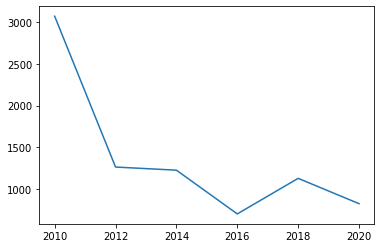

In [49]:
values = np.array(list(grass_areas.values()))
plt.plot(test_image_params['years'], values)

In [62]:
la_county_income_zipcode2 = ee.FeatureCollection("projects/california-lawn-detection/assets/income_zipcode2019")
la_county_income_zipcode = la_county_income_zipcode2.select(ee.List(['zipcode', '2019zipcod','shape_area']), ee.List(['ZipCode', 'Median_Income','Area_sqft']))




In [63]:
Zipcode_list = ['90802','90732','90744','90704','91362','91316']

In [61]:
keys = {'ImageYear','polygon','water_area','vegetation_trees_area', 'vegetation_grass_area', 'turf_area', 'impervious_area','soil_area', 'total_area'}
dictionary = {}
for i in keys:
    dictionary[i] = []

imagery = training_image_classified

    
for i in Zipcode_list:
    start = time()
    polygon = la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', i))

    dictionary['ImageYear'].append(nameof(imagery)) 
    dictionary['polygon'].append(i)
    
    water_area = area_calculation(imagery, 1, polygon, 20)
    dictionary['water_area'].append(water_area)
    
    vegetation_trees_area = area_calculation(imagery, 2, polygon, 20)
    dictionary['vegetation_trees_area'].append(vegetation_trees_area)
    
    vegetation_grass_area = area_calculation(imagery, 3, polygon, 20)
    dictionary['vegetation_grass_area'].append(vegetation_grass_area)
    
    turf_area = area_calculation(imagery, 4, polygon, 20)
    dictionary['turf_area'].append(turf_area)
    
    impervious_area = area_calculation(imagery, 6, polygon, 20)
    dictionary['impervious_area'].append(impervious_area)
    
    soil_area = area_calculation(imagery, 7, polygon, 20)
    dictionary['soil_area'].append(soil_area)

    total_area = water_area + vegetation_trees_area + vegetation_grass_area + turf_area + impervious_area + soil_area
    dictionary['total_area'].append(total_area)
    end = time()
    print(i, f'completed in {end-start} seconds.')

90802 completed in 10.099151134490967 seconds.
90732 completed in 8.45103120803833 seconds.
90744 completed in 8.424124956130981 seconds.
90704 completed in 98.49644899368286 seconds.
91362 completed in 21.4758038520813 seconds.
91316 completed in 49.545308113098145 seconds.


In [71]:
la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', '90802'))

In [72]:
la_county

In [62]:
pd.DataFrame(dictionary)

,turf_area,vegetation_trees_area,polygon,water_area,impervious_area,total_area,soil_area,ImageYear,vegetation_grass_area
0,0.164438,0.647374,90802,0.000000,12.688006,14.756617,0.760027,imagery,0.496773
1,0.159726,2.635687,90732,0.000000,2.946216,8.231549,1.869716,imagery,0.620204
2,0.190158,2.017314,90744,0.000000,15.849339,22.599279,3.527528,imagery,1.014940
3,9.193009,66.103575,90704,5.333700,35.695794,341.338173,138.000843,imagery,87.011250
4,0.023005,0.129558,91362,0.057541,1.716988,2.632023,0.202211,imagery,0.502720
5,0.763596,4.772787,91316,0.004292,7.122218,14.764068,0.461717,imagery,1.639458


In [45]:
# classified = training_image_classified

# water_area = area_calculation(classified, 1, la_county, 20)
# vegetation_trees_area = area_calculation(classified, 2, la_county, 20)
# vegetation_grass_area = area_calculation(classified, 3, la_county, 20)
# turf_area = area_calculation(classified, 4, la_county, 20)
# impervious_area = area_calculation(classified, 6, la_county, 20)
# soil_area = area_calculation(classified, 7, la_county, 20)

# total_area = water_area + vegetation_trees_area + vegetation_grass_area + turf_area + impervious_area + soil_area

# water_percentage = water_area / total_area
# vegetation_trees_percentage = vegetation_trees_area / total_area
# vegetation_grass_percentage = vegetation_grass_area / total_area
# turf_percentage = turf_area / total_area
# impervious_percentage = impervious_area / total_area
# soil_percentage = soil_area / total_area